# Assignment 10: Analyzing Text Representations

**Author:** Stefan Mauch  
**Course:** EN.705.603.81.SP25  
**Notebook:** analyze_text_representations.ipynb  
**Objective:** Evaluate the impact of preprocessing techniques, chunking parameters, and vocabulary size on TF-IDF and BoW vectorizers for clustering effectiveness.


In [2]:
# import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

sys.path.append("..")
from modules.utils.bow import Bag_of_Words
from modules.utils.tfidf import TF_IDF
from modules.utils.text_processing import process_text

### 1. Load Corpus

In [5]:
# Load all cleaned documents from storage
storage_path = "../storage"
documents = []

for filename in sorted(os.listdir(storage_path)):
    if filename.endswith(".txt.clean"):
        with open(os.path.join(storage_path, filename), "r", encoding="latin-1") as f:
            documents.append(f.read())

print(f"Loaded {len(documents)} documents.")


Loaded 150 documents.


### 2. Preprocessing Comparison (Stemming vs. Lemmatization vs. None)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stefanmauch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/stefanmauch/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


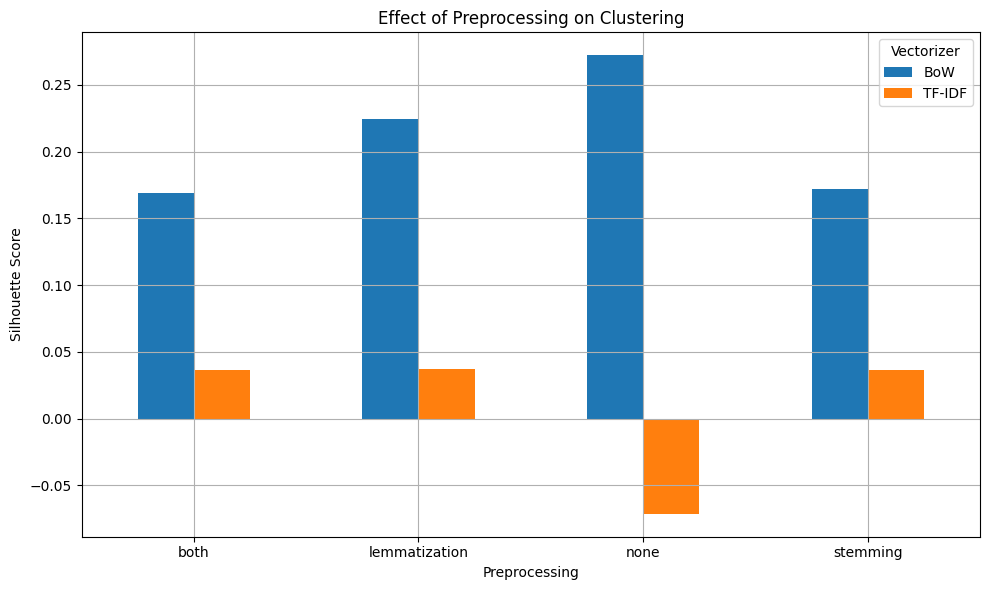


Silhouette Scores:


,Preprocessing,Vectorizer,Silhouette
0,none,TF-IDF,-0.071409
1,none,BoW,0.272257
2,stemming,TF-IDF,0.036313
3,stemming,BoW,0.172227
4,lemmatization,TF-IDF,0.037021
5,lemmatization,BoW,0.224198
6,both,TF-IDF,0.036581
7,both,BoW,0.169281


In [7]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

preprocessing_modes = {
    "none": lambda text: process_text(text),
    "stemming": lambda text: process_text(text, use_stemming=True),
    "lemmatization": lambda text: process_text(text, use_lemmatization=True),
    "both": lambda text: process_text(text, use_stemming=True, use_lemmatization=True)
}

results = []

for mode, processor in preprocessing_modes.items():
    processed_docs = [processor(doc) for doc in documents]
    
    # TF-IDF
    tfidf = TF_IDF().fit(processed_docs)
    tfidf_vectors = [tfidf.transform(doc) for doc in processed_docs]
    tfidf_matrix = np.array([
        [doc.get(word, 0.0) for word in tfidf.vocabulary_] for doc in tfidf_vectors
    ])
    kmeans = KMeans(n_clusters=5, random_state=42).fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    results.append({
        "Preprocessing": mode,
        "Vectorizer": "TF-IDF",
        "Silhouette": score
    })
    
    # BoW
    bow = Bag_of_Words().fit(processed_docs)
    bow_vectors = [bow.transform(doc) for doc in processed_docs]
    bow_matrix = np.array([
        [doc.get(word, 0.0) for word in bow.vocabulary_] for doc in bow_vectors
    ])
    kmeans = KMeans(n_clusters=5, random_state=42).fit(bow_matrix)
    score = silhouette_score(bow_matrix, kmeans.labels_)
    results.append({
        "Preprocessing": mode,
        "Vectorizer": "BoW",
        "Silhouette": score
    })


scores_df = pd.DataFrame(results)

# Pivot for plotting
pivot_df = scores_df.pivot(index="Preprocessing", columns="Vectorizer", values="Silhouette")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6), title="Effect of Preprocessing on Clustering")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Display the raw scores
print("\nSilhouette Scores:")
display(scores_df)


### 3. Chunking & Overlap Analysis

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stefanmauch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


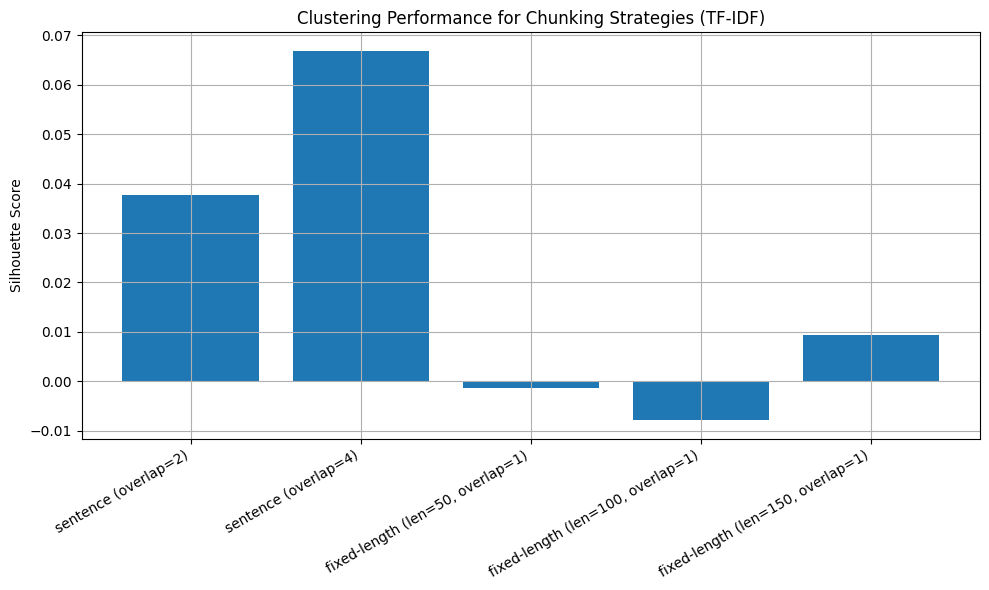

sentence (overlap=2): 0.0377
sentence (overlap=4): 0.0669
fixed-length (len=50, overlap=1): -0.0014
fixed-length (len=100, overlap=1): -0.0078
fixed-length (len=150, overlap=1): 0.0094


In [9]:
# Section 3: Chunking & Overlap Analysis
import re
from nltk.tokenize import sent_tokenize
nltk.download('punkt')  # Ensure sentence tokenizer is available

def chunk_documents(documents, strategy='sentence', overlap_size=2, fixed_length=100):
    chunks = []
    for doc in documents:
        if strategy == 'sentence':
            sentences = sent_tokenize(doc)
            for i in range(0, len(sentences) - overlap_size + 1):
                chunk = ' '.join(sentences[i:i + overlap_size])
                chunks.append(chunk)
        elif strategy == 'fixed-length':
            words = re.findall(r'\b\w+\b', doc)
            for i in range(0, len(words) - fixed_length + 1, fixed_length - overlap_size):
                chunk = ' '.join(words[i:i + fixed_length])
                chunks.append(chunk)
    return chunks

chunk_configs = [
    ("sentence", 2),
    ("sentence", 4),
    ("fixed-length", 1, 50),
    ("fixed-length", 1, 100),
    ("fixed-length", 1, 150),
]

chunk_results = []
preprocessor = lambda text: process_text(text, use_stemming=True)

for config in chunk_configs:
    if config[0] == "sentence":
        strategy, overlap = config
        label = f"{strategy} (overlap={overlap})"
        chunks = chunk_documents(documents, strategy=strategy, overlap_size=overlap)
    else:
        strategy, overlap, fixed_length = config
        label = f"{strategy} (len={fixed_length}, overlap={overlap})"
        chunks = chunk_documents(documents, strategy=strategy, overlap_size=overlap, fixed_length=fixed_length)
    
    # Preprocess
    processed_chunks = [preprocessor(chunk) for chunk in chunks]

    # TF-IDF
    tfidf = TF_IDF().fit(processed_chunks)
    tfidf_vectors = [tfidf.transform(doc) for doc in processed_chunks]
    tfidf_matrix = np.array([
        [doc.get(word, 0.0) for word in tfidf.vocabulary_] for doc in tfidf_vectors
    ])
    kmeans = KMeans(n_clusters=5, random_state=42).fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    chunk_results.append((label, score))

# Plotting
labels, scores = zip(*chunk_results)
plt.figure(figsize=(10, 6))
plt.bar(labels, scores)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Silhouette Score")
plt.title("Clustering Performance for Chunking Strategies (TF-IDF)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display chunk results
for label, score in chunk_results:
    print(f"{label}: {score:.4f}")

### 4. Vocabulary Size Comparison

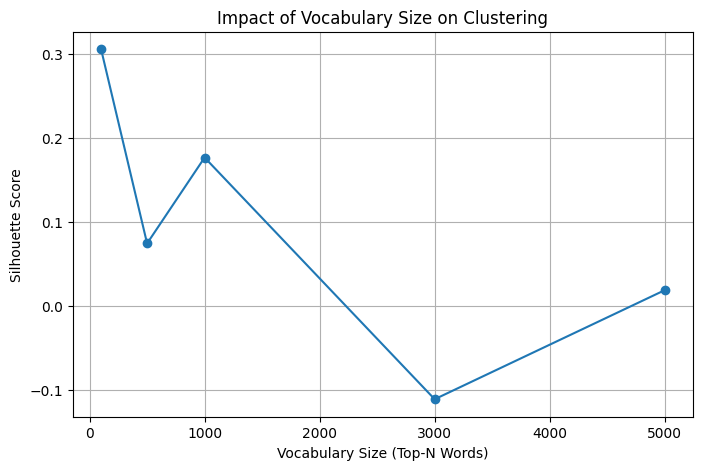

In [11]:
from collections import Counter

# Build top-N frequency vocab sizes
vocab_sizes = [100, 500, 1000, 3000, 5000]

# Preprocess using best mode from Task 2
processed_docs = [process_text(doc, use_stemming=True) for doc in documents]

# Token frequency distribution
all_tokens = []
for doc in processed_docs:
    all_tokens.extend(doc.split())

token_counts = Counter(all_tokens)
top_tokens = {n: set([t for t, _ in token_counts.most_common(n)]) for n in vocab_sizes}

# Evaluate clustering quality for top-N vocab sizes
vocab_results = {}

for n, top_vocab in top_tokens.items():
    # Filter tokens in docs
    trimmed_docs = [
        ' '.join([token for token in doc.split() if token in top_vocab])
        for doc in processed_docs
    ]
    
    tfidf = TF_IDF().fit(trimmed_docs)
    tfidf_vectors = [tfidf.transform(doc) for doc in trimmed_docs]
    tfidf_matrix = np.array([
        [doc.get(word, 0.0) for word in tfidf.vocabulary_] for doc in tfidf_vectors
    ])
    
    kmeans = KMeans(n_clusters=5, random_state=42).fit(tfidf_matrix)
    vocab_results[n] = silhouette_score(tfidf_matrix, kmeans.labels_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(vocab_results.keys()), list(vocab_results.values()), marker='o')
plt.title("Impact of Vocabulary Size on Clustering")
plt.xlabel("Vocabulary Size (Top-N Words)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()
